<div style = "text-align:center;">
<h1> Aula 09 - Modelo de Visão computacional</h1>

### Classificação de categorias de borboletas utilizando o TensorFlow

- O intuito é realizar a classificação de borboletas em 75 classes diferentes 
- O dataset inclui cerca de mais de mil imagens, incluindo imagens para teste de modelo 

<div style = "text-align:center;">

## 1° Importação do dataset via Kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\roger\.cache\kagglehub\datasets\phucthaiv02\butterfly-image-classification\versions\2


<div style = "text-align:center;">

## 2° Teste de importação do database

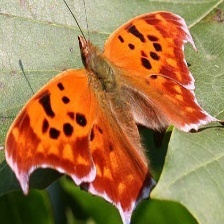

In [4]:
from IPython.display import	Image
Image(filename='train/Image_46.jpg')

<div style = "text-align:center;">

  ## 3° Construção da rede neural </div>


- Importação das bibliotecas

In [5]:
import pandas as pd
import tensorflow as tf
import keras as K
# Importar K e suas funções necessárias
from keras.models import Sequential
from keras.layers import Conv2D, Dropout,MaxPooling2D, Flatten, Dense

In [6]:
# Inicializando a Rede Neural Convolucional
classifier = Sequential()

In [7]:
# 32 features; formato 3x3; Imagens 64x64; Array 3D (RGB)

# Primeira Camada de Convolução
classifier.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Segunda Camada de Convolução
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Terceira Camada de Convolução
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Camada totalmente conectada
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))

#  Camada de saída com 75 neurônios e softmax
classifier.add(Dense(units = 75, activation = 'softmax'))

#  Compilação para problema de múltiplas classes
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<div style = "text-align:center;">

## 4º Pré Processamento

- O dataset proveniente do kaggle possui uma pasta de treino com as imagens, e o csv de referência indicando as suas respectivas classes. Possui também uma pasta de validação para teste de eficiência do modelo. Contudo como não há um csv para a validação não seria possível fazer uma comparação entre o modelo e o real. Portanto foi realizado a separação das imagens de treino para parte funcionar como validação. Apresentando ao modelo imagens inéditas.

- Lembrando que a divisão é feita de forma aleatória porém controlada, através da separação imposta pelo 'random_state'

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Lê o CSV
df = pd.read_csv('Training_set.csv')

# Divide manualmente -- Para execução sem parâmetros de separação, basta retirar o "random_state"
#A opção 'stratify=df['label']' garante que a proporção das classes no treino e validação será a mesma — ou seja, mantém o balanceamento entre as categorias.
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Gera imagens com transformação (para treino)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Apenas reescala (para validação)
val_datagen = ImageDataGenerator(rescale=1./255)

# Diretório com imagens
image_dir = 'train'

# Conjunto de treino
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Conjunto de validação
validation_set = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


Tendo em vista que estamos trabalhando com imagens + classificação em banco CSV temos o método flow_from_directory não será efetivo. Portanto será utilizado a seguinte forma:

Como observado, a separação foi feita devido ao modelo do kaggle não ter fornecido uma validação csv para aferição dos resultados. Portanto foi dividido o modelo de treino para utilizar parte para treino e parte para validação.

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [47]:
# Executando o treinamento
classifier.fit(
    training_set,
    validation_data=validation_set,
    epochs=5,
    callbacks=[early_stopping]
)


C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4822 - loss: 1.7394 - val_accuracy: 0.7800 - val_loss: 0.8774
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5044 - loss: 1.6266 - val_accuracy: 0.7546 - val_loss: 0.8967
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5168 - loss: 1.5852 - val_accuracy: 0.7854 - val_loss: 0.8537
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5132 - loss: 1.5604 - val_accuracy: 0.7631 - val_loss: 0.8910
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 17832s 220s/step - accuracy: 0.5152 - loss: 1.5945 - val_accuracy: 0.7500 - val_loss: 0.8480


<div style = "text-align:center;">
Como se pode ver a cada época a acurácia aumenta, ou seja o treinamento foi executado com sucesso

<div style = "text-align:center;">

## 5º Teste do modelo

In [48]:
loss, accuracy = classifier.evaluate(validation_set)
print(f"Acurácia no conjunto de validação: {accuracy:.2%}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.7539 - loss: 0.8839
Acurácia no conjunto de validação: 75.00%


In [49]:
# Pega os caminhos reais usados no conjunto de validação
validation_filenames = validation_set.filepaths
print(validation_filenames[:5])  # mostra os 5 primeiros


['train\\Image_4100.jpg', 'train\\Image_6404.jpg', 'train\\Image_5730.jpg', 'train\\Image_1234.jpg', 'train\\Image_657.jpg']


- A seguinte validação capta de forma aleatória no validation.path uma imagem inédita para realizar a aplicação do modelo 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Imagem: train\Image_2652.jpg
Classe prevista: WOOD SATYR


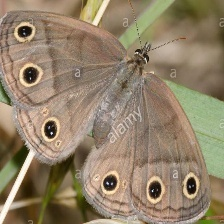

In [72]:
from keras.preprocessing import image
from IPython.display import Image, display
import numpy as np
import random

# Selecionar uma imagem aleatória da validação
img_path = random.choice(validation_set.filepaths)  # Seleção aleatória
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Fazer a predição
result = classifier.predict(img_array)
predicted_class_index = np.argmax(result) if result.shape[1] > 1 else int(result[0][0] >= 0.5)

# Obter o nome da classe
class_labels = {v: k for k, v in training_set.class_indices.items()}
predicted_class = class_labels[predicted_class_index]

# Mostrar resultado
print(f"Imagem: {img_path}")
print(f"Classe prevista: {predicted_class}")
display(Image(filename=img_path))


In [56]:
img = 'Image_4100.jpg'

if img in train_df['filename'].values:
    print("⚠️ A imagem está no TREINO.")
elif img in val_df['filename'].values:
    print("✅ A imagem está na VALIDAÇÃO.")
else:
    print("❓ A imagem não está em nenhum dos conjuntos.")


✅ A imagem está na VALIDAÇÃO.


<div style = "text-align:center;">

## 6º Matriz de confusão

- A matriz de confusão é uma ideal para entender quais classes o modelo acerta ou confunde — especialmente útil quando há tem mais de duas classes

importação das bibliotecas necessárias

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


- Gerar previsões e rótulos verdadeiros

In [60]:
# Obter previsões do modelo no conjunto de validação
Y_pred = classifier.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)  # Pegamos o índice da maior probabilidade (classe prevista)

# Rótulos verdadeiros
y_true = validation_set.classes


C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step


- Matriz de confusão 

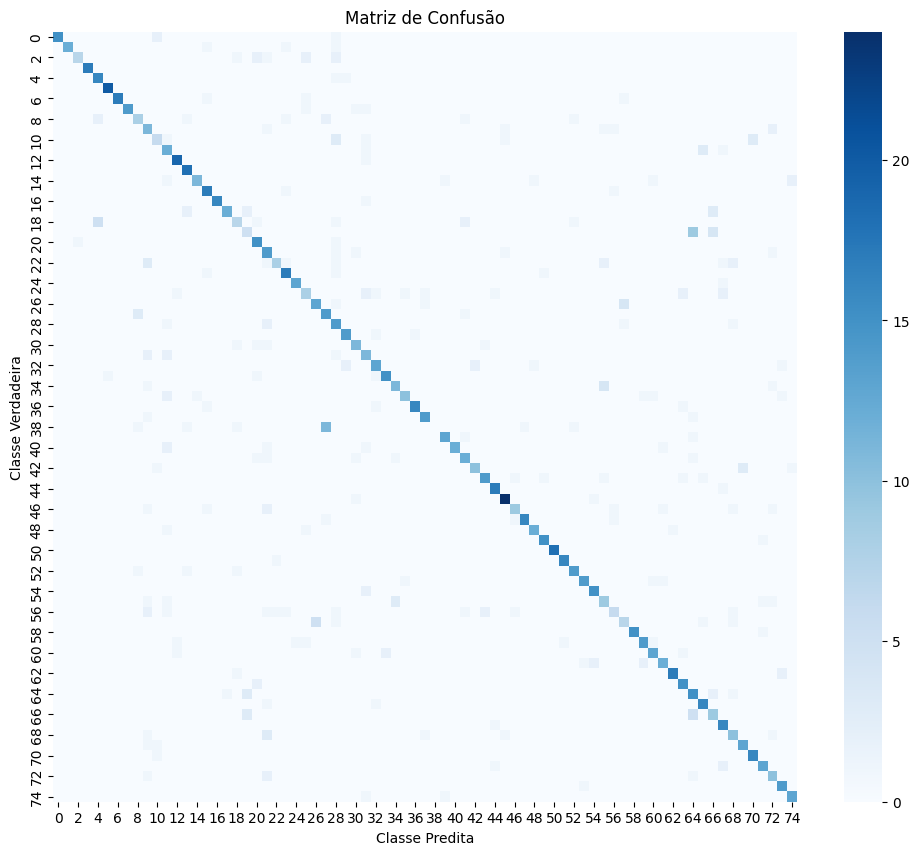

In [61]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()


- Relatório por classe 

In [62]:
target_names = list(validation_set.class_indices.keys())

print("Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=target_names))


Relatório de Classificação:

                           precision    recall  f1-score   support

                   ADONIS       1.00      0.83      0.91        18
AFRICAN GIANT SWALLOWTAIL       1.00      0.80      0.89        15
           AMERICAN SNOOT       0.88      0.47      0.61        15
                    AN 88       1.00      1.00      1.00        17
                  APPOLLO       0.70      0.89      0.78        18
                    ATALA       0.95      1.00      0.98        20
 BANDED ORANGE HELICONIAN       1.00      0.85      0.92        20
           BANDED PEACOCK       1.00      0.82      0.90        17
            BECKERS WHITE       0.62      0.50      0.55        16
         BLACK HAIRSTREAK       0.44      0.65      0.52        17
              BLUE MORPHO       0.55      0.40      0.46        15
        BLUE SPOTTED CROW       0.50      0.71      0.59        17
           BROWN SIPROETA       0.86      0.95      0.90        20
            CABBAGE WHITE       

C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati